# Part 1: Selection Strategies in a Pool-Based Setting
___

## Install libraries

In [ ]:
!pip install numpy
!pip install matplotlib
!pip install sklearn

## Add Parzen Window Classifier

In [ ]:
import numpy as np

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics.pairwise import pairwise_kernels


class PWC(BaseEstimator, ClassifierMixin):

    def __init__(self, n_classes, metric='rbf', n_neighbours=None, **kwargs):
        """
        Parzen Window Classifier (PWC) is a simple and probabilistic classifier. This classifier is based on a
        non-parametric density estimation obtained by applying a kernel function.

        Parameters
        ----------
        n_classes: int,
            This parameters indicates the number of available classes.
        metric: str,
            The metric must a be a valid kernel defined by the function sklearn.metrics.pairwise.pairwise_kernels.
        n_neighbours: int,
            Number of nearest neighbours. Default is None, which means all available samples are considered.
        kwargs: str,
            Any further parameters are passed directly to the kernel function.

        Attributes
        ----------
        n_classes: int,
            This parameters indicates the number of available classes.
        metric: str,
            The metric must a be a valid kernel defined by the function sklearn.metrics.pairwise.pairwise_kernels.
        n_neighbours: int,
            Number of nearest neighbours. Default is None, which means all available samples are considered.
        kwargs: str,
            Any further parameters are passed directly to the kernel function.
        X: array-like, shape = [n_samples, n_features]
            The sample matrix X is the feature matrix representing the samples.
        y: array-like, shape = [n_samples] or [n_samples, n_outputs]
            It contains the class labels of the training samples.
            The number of class labels may be variable for the samples.
        Z: array-like, [n_samples, n_classes]
            The class labels are represented by counting vectors. An entry Z[i,j] indicates how many class labels of class j
            were provided for training sample i.

        References
        ----------
        O. Chapelle, "Active Learning for Parzen Window Classifier",
        Proc. Tenth Int'l Workshop Artificial Intelligence and Statistics, 2005.
        """

        self.n_classes = n_classes
        self.metric = metric
        self.n_neighbours = n_neighbours
        self.kwargs = kwargs
        self.X = None
        self.y = None
        self.Z = None

    def fit(self, X, y):
        """
        Fit the model using X as training data and y as class labels.

        Parameters
        ----------
        X: matrix-like, shape = [n_samples, n_features]
            The sample matrix X is the feature matrix representing the samples.
        y: array-like, shape = [n_samples] or [n_samples, n_outputs]
            It contains the class labels of the training samples.
            The number of class labels may be variable for the samples.

        Returns
        -------
        self: PWC,
            The PWC is fitted to the training data.
        """

        self.X = X
        self.y = y

        if np.size(X, 0) == 0:
            return self

        # convert labels to count vectors
        self.Z = np.zeros((np.size(X, 0), self.n_classes))
        for i in range(np.size(self.Z, 0)):
            self.Z[i, y[i]] += 1

        return self

    def predict_proba(self, X, **kwargs):
        """
        Return probability estimates for the test data X.

        Parameters
        ----------
        X:  array-like, shape = [n_samples, n_features] or shape = [n_samples, m_samples] if metric == 'precomputed'
            Test samples.
        C: array-like, shape = [n_classes, n_classes]
            Classification cost matrix.

        Returns
        -------
        P:  array-like, shape = [t_samples, n_classes]
            The class probabilities of the input samples. Classes are ordered by lexicographic order.
        """

        # no training data -> random prediction
        if np.size(X, 0) == 0:
            return np.full((np.size(X, 0), self.n_classes), 1. / self.n_classes)

        # if normalize is false, the probabilities are frequency estimates
        normalize = kwargs.pop('normalize', True)

        # calculating metric matrix
        K = pairwise_kernels(X, self.X, metric=self.metric, **self.kwargs)

        if self.n_neighbours is None:
            # calculating labeling frequency estimates
            P = K @ self.Z
        else:
            if np.size(self.X, 0) < self.n_neighbours:
                n_neighbours = np.size(self.X, 0)
            else:
                n_neighbours = self.n_neighbours
            indices = np.argpartition(K, -n_neighbours, axis=1)[:, -n_neighbours:]
            P = np.empty((np.size(X, 0), self.n_classes))
            for i in range(np.size(X, 0)):
                P[i, :] = K[i, indices[i]] @ self.Z[indices[i], :]

        if normalize:
            # normalizing probabilities of each sample
            normalizer = np.sum(P, axis=1)
            P[normalizer > 0] /= normalizer[normalizer > 0, np.newaxis]
            P[normalizer == 0, :] = [1 / self.n_classes] * self.n_classes
            # normalizer[normalizer == 0.0] = 1.0
            # for y_idx in range(self.n_classes):
            #     P[:, y_idx] /= normalizer

        return P

    def predict(self, X, **kwargs):
        """
        Return class label predictions for the test data X.

        Parameters
        ----------
        X:  array-like, shape = [n_samples, n_features] or shape = [n_samples, m_samples] if metric == 'precomputed'
            Test samples.

        Returns
        -------
        y:  array-like, shape = [n_samples]
            Predicted class labels class.
        """
        C = kwargs.pop('C', None)

        if C is None:
            C = np.ones((self.n_classes, self.n_classes))
            np.fill_diagonal(C, 0)

        P = self.predict_proba(X, normalize=True)
        return np.argmin(np.dot(P, C), axis=1)


def largest_indices(array, n):
    """
    Returns the n largest indices from a numpy array.

    Parameters
    ----------
    array: array-like
        Array of values.
    n: int
        Number of the searched maximal values.

    Returns
    -------
    indices: array-like, shape = [n]
        Indices of the n maximal values of the array.
    """
    flat = array.flatten()
    indices = np.argpartition(flat, -n)[-n:]
    indices = indices[np.argsort(-flat[indices])]
    return np.unravel_index(indices, array.shape)


## Import libraries and set things up

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

plt.style.use('ggplot')
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

## Generate a data set

In [ ]:
%matplotlib notebook
"""Create Dataset."""
X, y = make_blobs(300, centers=2, cluster_std=2.3, random_state=RANDOM_SEED)
new_center = max(X, key=lambda x: x[1])
size = 100
X1, y1 = np.c_[np.random.normal(loc=new_center[0], size=size),
               np.random.normal(loc=new_center[1], size=size)], np.ones(size)
X, y = np.r_[X, X1], np.r_[y, y1].astype(int)


## Plot dataset method
def plot_dataset(x):
    plt.plot(x[:, 0], x[:, 1], '.')


def plot_dataset_with_class(x, y):
    uniques = np.unique(y)
    [plt.plot(x[:, 0][y == unique], x[:, 1][y == unique], '.') for unique in uniques]

plt.figure()
plot_dataset(X)
plt.show()

In [ ]:
# visualize sampling and decision boundary
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, X, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    X0, X1 = X[:, 0], X[:, 1]
    xx, yy = make_meshgrid(X0, X1)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

## Pool-base Active Learning
___
Describe the different steps in a general pool-based active learning
scenario and find each step in the following code.


In [ ]:
## plot sampling
def plot_sampling(X, y, clf, selection_strategy, num_queries=5, time_between_sampling=0.5, ax=None):
    """
    Visualization of the sampling with the decision boundary.

    Parameters
    ----------
    X: array_like
        Numpy array with samples as rows and features as columns.
    y: array_like
        Corresponding labels of the samples.
    clf: sklearn classifier
        Classifier that will be used in the AL process.
    selection_strategy: function
        Method that queries a sample and return an index.
    num_queries: int
        Number of AL queries.
    """
    # Define labeled and unlabeled pool
    X_unlabeled, y_unlabeled = X, y 
    X_labeled, y_labeled = list(), list()
    
    if ax:
        ax.cla()
        countour = None
        plot_dataset_with_class(X, y)

    for step in range(num_queries):
        
        num_classes = len(np.unique(y_labeled))
        
        if num_classes < 2:
            query_idx = random_sampling(X_unlabeled)
            query_sample, query_label = X_unlabeled[query_idx], y_unlabeled[query_idx]
            
            X_unlabeled = np.delete(X_unlabeled, query_idx, axis=0)
            y_unlabeled = np.delete(y_unlabeled, query_idx, axis=0)
            
            X_labeled.append(query_sample)
            y_labeled.append(query_label)
            
            if ax:
                ax.plot(query_sample[0], query_sample[1], 'oy', markeredgewidth=1, 
                        markeredgecolor=(0, 0, 0, 1), markersize=8)
                
        else:
            clf.fit(np.array(X_labeled), np.array(y_labeled).astype(int))
            
                
            if selection_strategy.__name__ == 'random_sampling':
                query_idx = selection_strategy(X_unlabeled)
            elif selection_strategy.__name__ == 'uncertainty_sampling':
                query_idx = selection_strategy(X_unlabeled, clf)
            elif selection_strategy.__name__ == 'ensemble_based_sampling':
                query_idx = selection_strategy(X_unlabeled, X_labeled, y_labeled)
            elif selection_strategy.__name__ == 'expected_error_reduction':
                query_idx = selection_strategy(X_unlabeled, X_labeled, y_labeled, clf)

            # Implement your own strategies here! 

            query_sample, query_label = X_unlabeled[query_idx], y_unlabeled[query_idx]
            
            X_unlabeled = np.delete(X_unlabeled, query_idx, axis=0)
            y_unlabeled = np.delete(y_unlabeled, query_idx, axis=0)
            
            X_labeled.append(query_sample)
            y_labeled.append(query_label)

            if ax: 
                clf.fit(np.array(X_labeled), np.array(y_labeled).astype(int))
                # plot decision boundary
                if countour is not None:
                    for coll in countour.collections:
                        coll.remove()
                        
                countour = plot_contours(plt.gca(), clf, X, alpha=0.5, cmap=plt.cm.coolwarm)

                ax.plot(query_sample[0], query_sample[1], 'oy', markeredgewidth=1,
                        markeredgecolor=(0, 0, 0, 1), markersize=8)

        if ax: 
            plt.gcf().canvas.draw()
            plt.pause(time_between_sampling)
    
def random_sampling(pool):
    """Randomly selects an instances.

    Parameters
    ----------
    X: array_like
        Array of all unlabeled instances.

    Returns
    -------
    index: int
        Random index of all instances.
    """
    return np.random.randint(len(pool))

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
fig.show()
fig.canvas.draw()

In [ ]:
# run this code and watch the figure above
clf = PWC(n_classes=2, gamma=1)
plot_sampling(X, y, clf, random_sampling, num_queries=10, time_between_sampling=.5, ax=plt.gca())

## Selection Strategies:
___
- Uncertainty Sampling,
- Ensemble-based Sampling

### Uncertainty Sampling

In [ ]:
def uncertainty_sampling(X_unlabeled, clf):
    """Queries the instance the model is least certain about.

    Parameters
    ----------
    X_unlabeled: ndarray
       Array of all unlabeled instances.
    clf: sklearn classifier
        The current model.

    Returns
    -------
    index: int
        Index of the instance that the model is least certain about.
    """
    # binary problem assumed
    probas = clf.predict_proba(X_unlabeled)
    score = np.max(probas, axis=1)
    idx = np.argmin(score)
    return idx

### Ensemble-based Sampling

In [ ]:
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

In [ ]:
def ensemble_based_sampling(X_unlabeled, X_labeled, y_labeled, 
                            models=[SVC(),
                                    GaussianNB(), 
                                    DecisionTreeClassifier(),
                                    RandomForestClassifier(),
                                    AdaBoostClassifier()]):
    """
    
    Parameters
    ----------
    X_unlabeled: ndarray
       Array of all unlabeled instances.
    X_labeled: list
        Array of all labeled instances.
    y_labeled: list
        Array of all labels.
    clfs: list
        List of sklearn models.

    Returns
    -------
    index: int
        Index of the instance that minimizes the generalization error.
    """
    # Create and Train all models
    for model in models:
        model.fit(np.array(X_labeled), np.array(y_labeled).astype(int))
    
    # Let the trained models vote for unlabeled data
    votes = np.zeros((len(X_unlabeled), len(models)))
    for i, model in enumerate(models):
        votes[:, i] = model.predict(X_unlabeled)
    
    # Compute vote disagreement
    vote_entropy = []
    for vote in votes:
        vote_entropy.append(0.0)
        label_count = {}
        for label in vote:
            label_count[label] = label_count.setdefault(label, 0) + 1
        # Using vote entropy to measure disagreement
        for label in label_count.keys():
            vote_entropy[-1] -= label_count[label] / len(models) * \
                np.log(float(label_count[label]) / len(models))

    idx = np.random.choice(np.where(np.isclose(vote_entropy, np.max(vote_entropy)))[0])
    return idx

## Visualize

### Uncertainty Sampling
- Decision boundary

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
fig.show()
fig.canvas.draw()

In [ ]:
# run this code and watch the figure above
clf = PWC(n_classes=2, gamma=1)
plot_sampling(X, y, clf, uncertainty_sampling, num_queries=10, time_between_sampling=.5, ax=plt.gca())

### Ensemble-based Sampling
- Decision boundary
- Reliability 

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
fig.show()
fig.canvas.draw()

In [ ]:
# run this code and watch the figure above
clf = PWC(n_classes=2, gamma=1)
plot_sampling(X, y, clf, ensemble_based_sampling, num_queries=10, time_between_sampling=0.5, ax=plt.gca())

## import libraries

In [ ]:
import copy 

import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.datasets import load_iris
from sklearn.manifold import TSNE
from sklearn.model_selection import KFold
from scipy.special import gamma
from sklearn.neighbors.kde import KernelDensity

## OPAL strategy

"Optimized Probabilistic Active Learning" ([Krempl, Kottke, Lemaire in Machine Learning 2015](https://link.springer.com/article/10.1007/s10994-015-5504-1))

In [ ]:
def comb(m, k):
    return gamma(m+1) / (gamma(k+1) * gamma(m-k+1))

def I(n, p, tau, m, k):
    constraint = ((n*p)+k) / ((n+m)+1e-19)
    if constraint < tau:
        equ = (1-tau)        * gamma(1-k+m+n- n*p) * gamma(2+k+ n*p) / gamma(3+m+n)
    elif constraint == tau: 
        equ = (tau - tau**2) * gamma(1-k+m+n- n*p) * gamma(1+k+ n*p) / gamma(2+m+n)
    elif constraint > tau:
        equ = tau            * gamma(2-k+m+n- n*p) * gamma(1+k+ n*p) / gamma(3+m+n)
    return comb(m, k) * equ

## Vectorized form
def I_arr(n, p, tau, m, k):
    
    constraints = np.zeros(len(n)) + tau
    constraints[n+m != 0] = ((n[n+m != 0] * p[n+m != 0])+k) / ((n[n+m != 0]+m))
        
    gains = np.zeros(len(n))
    
    smaller = constraints < tau
    gains[smaller] = ((1-tau) * ((gamma(1 - k + m + n[smaller] - (n[smaller]*p[smaller])) * 
                           gamma(2 + k + (n[smaller]*p[smaller]))) / gamma(3 + m + n[smaller])))
    
    equal = constraints == tau
    gains[equal] = (tau - tau**2) * ((gamma(1 - k + m + n[equal] - (n[equal]*p[equal])) * 
                                      gamma(1 + k + (n[equal]*p[equal]))) / gamma(2 + m + n[equal]))
    
    bigger = constraints > tau
    gains[bigger] = tau * ((gamma(2 - k + m + n[bigger] -(n[bigger]*p[bigger])) * 
                            gamma(1 + k + (n[bigger]*p[bigger]))) / gamma(3 + m + n[bigger]))
    return comb(m, k) * gains


def probabilistic_gain(n, p, tau, m):
    first_factor = ((n+1)/m) * comb(n, n*p) 
    if type(n) == np.ndarray:
        return  first_factor * (I_arr(n, p, tau, 0, 0) - np.sum([I_arr(n, p, tau, m, k) for k in range(m+1)],axis=0))
    else:
        return first_factor * (I(n, p, tau, 0, 0) - np.sum([I(n, p, tau, m, k) for k in range(m+1)]))
    
def probabilistic_active_learning(X_unlabeled, X_labeled, y_labeled, clf, tau=.5, m_max=2,bw=2):
    # compute density
    densities = np.exp(KernelDensity(bw).fit(np.r_[X_unlabeled, X_labeled]).score_samples(X_unlabeled))
    n = np.max(clf.predict_proba(X_unlabeled, normalize=False), axis=1)
    p = clf.predict_proba(X_unlabeled)[:,1]
    dweighted_pgain = probabilistic_gain(n, p, tau, m_max) * densities
        
    return np.argmax(dweighted_pgain) 

## Visualize the behaviour

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
fig.show()
fig.canvas.draw()

In [ ]:
# run this code and watch the figure above
clf = PWC(n_classes=2, gamma=.05)
plot_sampling(X, y, clf, probabilistic_active_learning, num_queries=20, time_between_sampling=.5, ax=plt.gca())

## Discussion
___
Which of the previous methods seems to work best and why? How could
this be?

# Evaluate AL

In [ ]:
X, y = make_blobs(500,centers=5, random_state=42)
y = y % 2
plt.figure()
plt.scatter(X[:,0], X[:,1], c=y, marker='.')

In [ ]:
"""5 times 3 Fold Cross-Validation with 30 queries"""
## Define Parameters
strats = {'Random_Sampling':random_sampling,
          'Uncertainty_Sampling':uncertainty_sampling,
          'Ensemble-Based_Sampling':ensemble_based_sampling,
          'Probabilistic_Active_Learning':probabilistic_active_learning,}
reps = 5
folds = 3
num_queries = 45
num_classes = 2
scores = np.zeros((reps, len(strats), folds, num_queries))
random_state = 42
pwc_gamma = 0.05
cross_validation = KFold(n_splits=folds, random_state=random_state)

## Start cv
for irep in range(reps):
    print(irep)
    for ifold, (train_idx, test_idx) in enumerate(cross_validation.split(X)):
        # Get train and test set and define classifier
        X_train, y_train = X[train_idx], y[train_idx]
        X_test, y_test = X[test_idx], y[test_idx]
        clf_start = PWC(n_classes=num_classes, gamma=pwc_gamma)

        # Create labeled and unlabeled pool
        X_unlabeled_start, y_unlabeled_start = X_train, y_train
        X_labeled_start, y_labeled_start = list(), list()

        # Random sampling until all classes are found 
        while len(np.unique(y_labeled_start)) < num_classes:
            query_idx = random_sampling(X_unlabeled_start)
            query_sample, query_label = X_unlabeled_start[query_idx], y_unlabeled_start[query_idx]

            X_unlabeled_start = np.delete(X_unlabeled_start, query_idx, axis=0)
            y_unlabeled_strat = np.delete(y_unlabeled_start, query_idx, axis=0)

            X_labeled_start.append(query_sample)
            y_labeled_start.append(query_label)

        # Fit classifier with randomly filled set
        clf_start.fit(np.array(X_labeled_start), np.array(y_labeled_start,dtype=int))

        # Iterate over all selection strategies
        for istrat, selection_strategy_name in enumerate(strats):
            # Get a copy of labeled, unlabeled start set and the classifier 
            X_unlabeled, y_unlabeled = X_unlabeled_start.copy(), y_unlabeled_start.copy()
            X_labeled, y_labeled = X_labeled_start.copy(), y_labeled_start.copy()
            clf = copy.deepcopy(clf_start)

            # Make queries for the specific srategie and train clf, get score at the end
            for iquery in range(num_queries):
                selection_strategy = strats[selection_strategy_name]

                if selection_strategy.__name__ == 'random_sampling':
                    query_idx = selection_strategy(X_unlabeled)
                elif selection_strategy.__name__ == 'uncertainty_sampling':
                    query_idx = selection_strategy(X_unlabeled, clf)
                elif selection_strategy.__name__ == 'ensemble_based_sampling':
                    query_idx = selection_strategy(X_unlabeled, X_labeled, y_labeled)
                elif selection_strategy.__name__ == 'expected_error_reduction':
                    query_idx = selection_strategy(X_unlabeled, X_labeled, y_labeled, clf)
                elif selection_strategy.__name__ == 'probabilistic_active_learning':
                    query_idx = selection_strategy(X_unlabeled, X_labeled, y_labeled, clf)

                query_sample, query_label = X_unlabeled[query_idx], y_unlabeled[query_idx]

                X_unlabeled = np.delete(X_unlabeled, query_idx, axis=0)
                y_unlabeled = np.delete(y_unlabeled, query_idx, axis=0)

                X_labeled.append(query_sample)
                y_labeled.append(query_label)
                clf.fit(X_labeled, y_labeled)
                scores[irep, istrat, ifold, iquery] = clf.score(X_test, y_test)

<IPython.core.display.Javascript object>


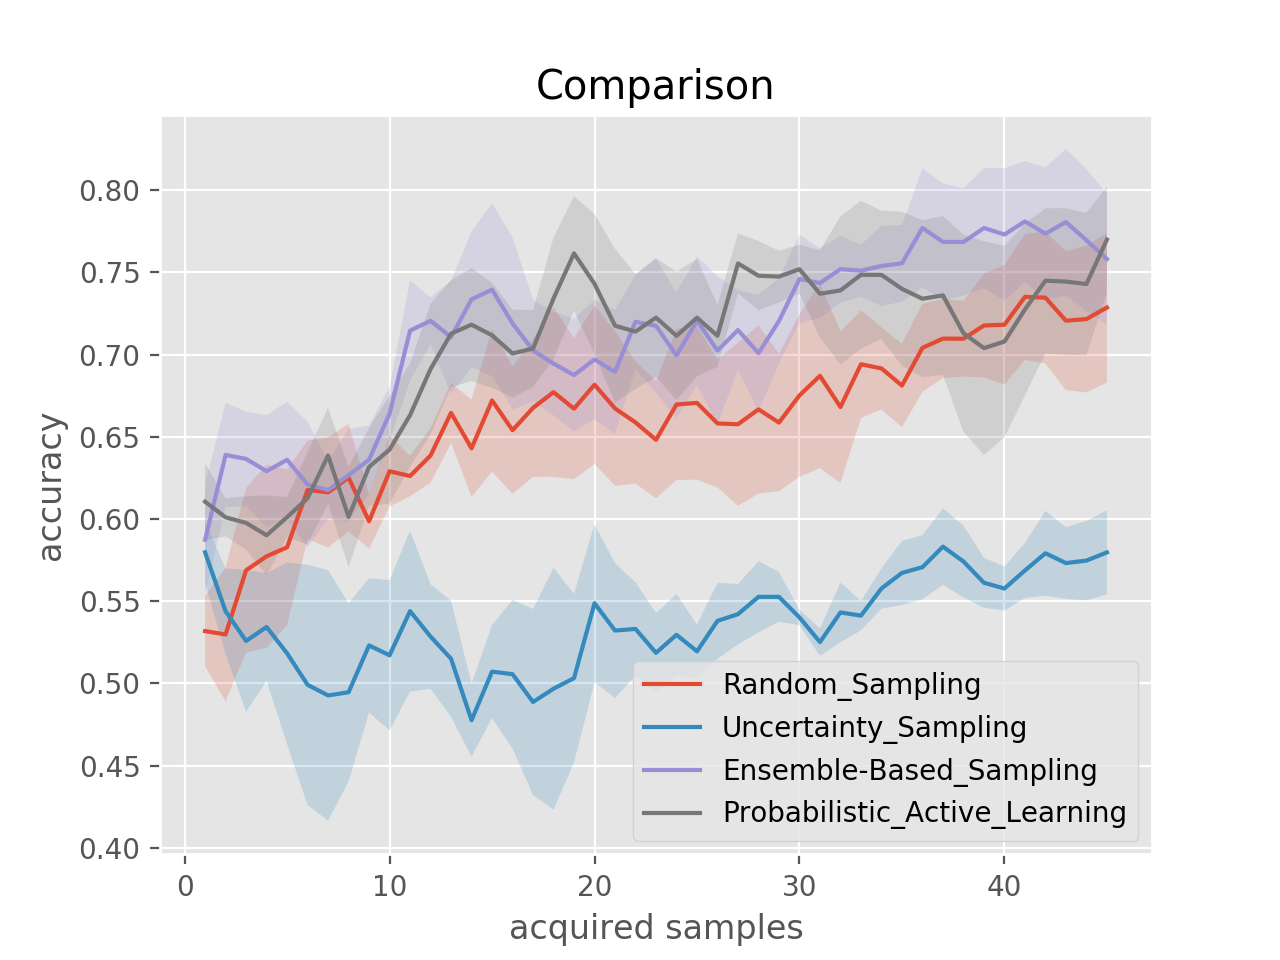

In [63]:
plt.figure()

plt.title('Comparison')

for cv_scores, strat_name in zip(np.mean(scores, axis=2), strats):
    means = np.mean(cv_scores, 0)
    std_err = np.std(cv_scores, 0) / np.sqrt(folds)
    x_axis = range(1, len(means)+1)

    plt.plot(x_axis, means, label=strat_name)
#    plt.fill_between(x_axis, means-std_err, means+std_err, alpha=0.2)
plt.xlabel('acquired samples')
plt.ylabel('accuracy')
plt.legend()

plt.show()